# jointmatch ssl experimentation on dbpedia (with data download & simpler augmentation)

this notebook implements and automates the training and evaluation of the jointmatch semi-supervised text classification model on the dbpedia dataset for various percentages of labeled data.

**based on:** the provided `epass-text-final.ipynb` and the jointmatch paper.

**key features:**
* automatic download and extraction of the dbpedia ontology dataset.
* implementation of jointmatch core components:
    * dual model training (co-training/cross-labeling).
    * adaptive thresholding for pseudo-label selection.
    * weighted disagreement/agreement update for unlabeled loss.
    * weak (dropout in model) and strong (random word dropout) augmentations.
* automated training loops for specified labeled data fractions (1%, 5%, 10%, 20%, 40%, 60%, 100%).
* saving the best performing model state dictionaries (`.pth` for both models) for each configuration.
* collection and visualization of performance metrics (accuracy vs. labeled percentage).

### notebook structure:

1.  **setup & imports:** load libraries, set up the environment.
2.  **configuration:** define hyperparameters (including jointmatch specific ones), data paths, and the list of labeled percentages.
3.  **data download:** function to download and extract the dbpedia dataset.
4.  **utility functions:** `set_seed`, `load_data`, `simple_tokenizer`, `build_vocab`, `textclassificationdataset`, `collate_batch`.
5.  **augmentation function:** `random_word_dropout` for strong augmentation.
6.  **model definition:** `textclassifier` (simplified from epass).
7.  **loss & optimizer definition:** `classification_criterion`.
8.  **training & evaluation functions:** `train_one_epoch_jointmatch`, `evaluate_jointmatch` (modified for dual models and jointmatch logic).
9.  **data preprocessing block:** loads raw data, cleans labels, builds vocabulary, creates base datasets and test loader.
10. **main experiment loop:** iterates through percentages, performs data splitting using cleaned data, sets up each run (dual models, optimizers, ema trackers), trains, evaluates (ensemble), saves the best models, and collects results.
11. **results summary & visualization:** prints final results and plots accuracy vs. labeled percentage. also shows detailed results for the 10% run.

In [1]:
# 1. Setup and Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torch.nn.utils.rnn import pad_sequence
import pandas as pd
import numpy as np
import random
import time
import math
import os
import gc # Garbage collector
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial # For collate function
import requests # For downloading data
import tarfile # For extracting .tar.gz files
import io # For handling byte streams
import copy # For deep copying models/optimizers if needed

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# 2. configuration & hyperparameters

# --- experiment setup ---
seed = 42
percentages_to_test = [0.01, 0.05, 0.1, 0.2, 0.4, 0.6, 1.0] # 1.0 = fully supervised
base_working_dir = "/kaggle/working/"
data_dir = os.path.join(base_working_dir, "data/dbpedia_jointmatch/")
base_model_save_dir = os.path.join(base_working_dir, "saved_models_jointmatch/")
os.makedirs(data_dir, exist_ok=True)
os.makedirs(base_model_save_dir, exist_ok=True)

# expected csv paths after download/extraction
train_csv = os.path.join(data_dir, "train.csv")
test_csv = os.path.join(data_dir, "test.csv")

# data subset sizes (for faster experimentation, set to none for full dataset)
num_train_samples = 50000  # using a subset
num_test_samples = 10000

# vocabulary settings
vocab_max_size = 25000
vocab_min_freq = 3

# --- model hyperparameters ---
embed_dim = 128
hidden_dim = 256
num_classes = 14  # dbpedia has 14 classes
dropout = 0.5 # dropout for weak augmentation & regularization

# --- training hyperparameters ---
batch_size = 64
learning_rate = 5e-4
weight_decay = 1e-5
num_epochs = 30 # adjust as needed for convergence vs. speed
grad_clip_norm = 1.0

# --- jointmatch specific hyperparameters ---
wu = 1.0  # weight for unlabeled loss
lambda_ema = 0.999 # ema decay for adaptive thresholding
tau = 0.95 # base confidence threshold
delta = 0.7 # disagreement weight (0.5 = equal weight, >0.5 favors disagreement)

# --- augmentation hyperparameters ---
dropout_word_prob = 0.1 # probability of dropping a word for strong augmentation

In [ ]:
# 3. data download function

dbpedia_url = "https://s3.amazonaws.com/fast-ai-nlp/dbpedia_csv.tgz"

def download_and_extract_dbpedia(url, target_dir):
    """downloads and extracts the dbpedia dataset if not already present."""
    train_path = os.path.join(target_dir, "train.csv")
    test_path = os.path.join(target_dir, "test.csv")

    if os.path.exists(train_path) and os.path.exists(test_path):
        print(f"dataset already found in {target_dir}")
        return train_path, test_path

    print(f"downloading dbpedia dataset from {url}...")
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()

        with tarfile.open(fileobj=io.bytesio(response.content), mode='r:gz') as tar:
            members_to_extract = []
            expected_files = ['dbpedia_csv/train.csv', 'dbpedia_csv/test.csv',
                              'dbpedia_csv/classes.txt', 'dbpedia_csv/readme.txt']
            for member in tar.getmembers():
                if member.name in expected_files and member.isfile():
                    member.name = os.path.basename(member.name)
                    members_to_extract.append(member)

            if not members_to_extract:
                raise ValueError("could not find expected files (train.csv, test.csv) in the archive.")

            print(f"extracting files to {target_dir}...")
            tar.extractall(path=target_dir, members=members_to_extract)

        if not (os.path.exists(train_path) and os.path.exists(test_path)):
            raise filenotfounderror("extraction failed or train.csv/test.csv not found after extraction.")

        print("dataset downloaded and extracted successfully.")
        return train_path, test_path

    except requests.exceptions.requestexception as e:
        print(f"error downloading dataset: {e}")
        raise
    except tarfile.tarerror as e:
        print(f"error extracting dataset: {e}")
        raise
    except exception as e:
        print(f"an unexpected error occurred: {e}")
        raise

# --- execute download ---
print("checking for dbpedia dataset...")
train_csv, test_csv = download_and_extract_dbpedia(dbpedia_url, data_dir)
print(f"using train csv: {train_csv}")
print(f"using test csv: {test_csv}")

Checking for DBPedia dataset...
Extracting files to /kaggle/working/data/dbpedia_jointmatch/...
Dataset downloaded and extracted successfully.
Using Train CSV: /kaggle/working/data/dbpedia_jointmatch/train.csv
Using Test CSV: /kaggle/working/data/dbpedia_jointmatch/test.csv


In [ ]:
# 4. data loading & vocab utilities

def set_seed(seed_value=42):
    """set seed for reproducibility."""
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

def load_data(csv_path, num_samples=None, seed=42):
    """loads data, renames columns, handles labels, and subsamples."""
    if not os.path.exists(csv_path):
        raise filenotfounderror(f"csv file not found at {csv_path}. please ensure download was successful.")

    df = pd.read_csv(csv_path, header=None)
    df.columns = ['label', 'title', 'content']
    # label adjustment happens later in the cleaning step, just combine text here
    df["text"] = df["title"].astype(str) + " " + df["content"].astype(str)
    df = df[['label', 'text']]

    # perform label conversion before sampling to ensure correct stratification
    df['label'] = df['label'] - 1 # map labels 1-14 to 0-13

    if num_samples is not None and num_samples < len(df):
        print(f"subsampling to {num_samples} samples...")
        # use train_test_split for stratified sampling (simpler and more robust)
        from sklearn.model_selection import train_test_split
        # check if stratification is possible
        label_counts = df['label'].value_counts()
        min_samples_needed = 1 # need at least 1 sample per class for split
        if len(label_counts) == num_classes and all(count >= min_samples_needed for count in label_counts) and num_samples >= num_classes:
            try:
                # we want a sample of size num_samples, so split off (len(df) - num_samples)
                df_sampled, _ = train_test_split(
                    df,
                    train_size=num_samples,
                    random_state=seed,
                    stratify=df['label']
                )
                df = df_sampled
                print(f"  stratified sample size: {len(df)}")
            except valueerror as e:
                print(f"  stratified sampling failed ({e}), falling back to random sampling.")
                df = df.sample(n=num_samples, random_state=seed)
        else:
            print(f"  not enough samples/classes for stratification, using random sampling.")
            df = df.sample(n=num_samples, random_state=seed)

    return df.reset_index(drop=True)

def simple_tokenizer(text):
    # reverted to simple split as nltk is removed
    return text.lower().split()

def build_vocab(texts, max_size=None, min_freq=2, specials=["<unk>", "<pad>"]):
    print(f"building vocabulary (max_size={max_size}, min_freq={min_freq})...")
    counter = counter()
    for i, text in enumerate(texts):
        tokens = simple_tokenizer(str(text)) # ensure text is string
        counter.update(tokens)
        if (i+1) % 10000 == 0:
            print(f'\r  processed {i+1}/{len(texts)} texts for vocab', end='')
    print('\r  finished processing texts for vocab.')

    vocab = {token: idx for idx, token in enumerate(specials)}
    vocab_idx = len(specials)
    words_and_freqs = sorted(counter.items(), key=lambda item: item[1], reverse=True)
    added_tokens = 0
    for word, freq in words_and_freqs:
        if max_size and vocab_idx >= max_size:
            break
        if freq < min_freq:
            continue
        if word not in vocab:
            vocab[word] = vocab_idx
            vocab_idx += 1
            added_tokens += 1

    itos = {idx: token for token, idx in vocab.items()}
    print(f"vocabulary size: {len(vocab)} (added {added_tokens} tokens)")
    unk_idx = vocab["<unk>"]
    pad_idx = vocab["<pad>"]
    return vocab, itos, unk_idx, pad_idx

class textclassificationdataset(dataset):
    def __init__(self, df, vocab, tokenizer, unk_idx, is_unlabeled=False):
        self.is_unlabeled = is_unlabeled
        if not self.is_unlabeled:
            # ensure labels are integers before storing
            # although cleaning is done earlier, this is a final safeguard
            self.labels = df['label'].astype(int).tolist()
        self.texts_original = df['text'].tolist() # keep original text for augmentation
        self.vocab = vocab
        self.tokenizer = tokenizer
        self.unk_idx = unk_idx

    def __len__(self):
        return len(self.texts_original)

    def __getitem__(self, idx):
        original_text = self.texts_original[idx]
        text_str = str(original_text) if pd.notna(original_text) else ""
        tokens = self.tokenizer(text_str)
        indices = [self.vocab.get(token, self.unk_idx) for token in tokens]
        tensor_indices = torch.tensor(indices, dtype=torch.long)

        if self.is_unlabeled:
            # for unlabeled data, return original text for strong augmentation
            # and the tokenized indices (for weak augmentation via model dropout)
            return original_text, tensor_indices
        else:
            # for labeled data, return tokenized indices and label
            label = self.labels[idx]
            # the error occurred here previously, labels should now be clean integers
            tensor_label = torch.tensor(label, dtype=torch.long)
            return tensor_indices, tensor_label

def collate_batch(batch, pad_idx, is_unlabeled=False):
    if is_unlabeled:
        original_text_list, text_indices_list, lengths = [], [], []
        for (_original_text, _indices) in batch:
            original_text_list.append(_original_text)
            text_indices_list.append(_indices)
            lengths.append(_indices.size(0))
        text_indices_padded = pad_sequence(text_indices_list, batch_first=True, padding_value=pad_idx)
        lengths_tensor = torch.tensor(lengths, dtype=torch.long)
        # return original texts, padded indices, and lengths
        return original_text_list, text_indices_padded, lengths_tensor
    else:
        # labeled data processing (as before)
        label_list, text_list, lengths = [], [], []
        for (_text, _label) in batch:
            label_list.append(_label)
            text_list.append(_text)
            lengths.append(_text.size(0))
        text_list = pad_sequence(text_list, batch_first=True, padding_value=pad_idx)
        label_list = torch.stack(label_list)
        lengths = torch.tensor(lengths, dtype=torch.long)
        return text_list, label_list, lengths

In [ ]:
# 5. augmentation function (random word dropout)

def random_word_dropout(text, dropout_prob=0.1):
    words = text.split() # use simple split
    if len(words) <= 1 or dropout_prob == 0:
        return text

    new_words = []
    for word in words:
        if random.random() > dropout_prob: # keep word with probability 1-dropout_prob
            new_words.append(word)

    # if all words are dropped, return the original text to avoid errors
    if not new_words:
        return text

    return ' '.join(new_words)

# function to apply strong augmentation (now dropout) to a batch of texts
def apply_strong_augmentation(texts_list, dropout_word_prob):
    return [random_word_dropout(text, dropout_prob=dropout_word_prob) for text in texts_list]

In [ ]:
# 6. model definition (simplified text classifier)

class textencoder(nn.module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, dropout, pad_idx):
        super().__init__()
        self.embedding = nn.embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.embed_dropout = nn.dropout(dropout)
        self.fc1 = nn.linear(embed_dim, hidden_dim)
        self.fc2 = nn.linear(hidden_dim, hidden_dim)
        self.dropout = nn.dropout(dropout) # weak augmentation
        self.relu = nn.relu()
        self.pad_idx = pad_idx

    def forward(self, text, lengths):
        embedded = self.embed_dropout(self.embedding(text))
        mask = (text != self.pad_idx).unsqueeze(-1).float()
        non_zero_lengths = lengths.unsqueeze(1).float().clamp(min=1)
        summed_embeddings = torch.sum(embedded * mask, dim=1)
        avg_pooled = summed_embeddings / non_zero_lengths
        out = self.fc1(avg_pooled)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

class textclassifier(nn.module):
    """simple classifier using the textencoder."""
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, dropout, pad_idx):
        super().__init__()
        self.encoder = textencoder(vocab_size, embed_dim, hidden_dim, dropout, pad_idx)
        self.classifier = nn.linear(hidden_dim, num_classes)

    def forward(self, text, lengths):
        features = self.encoder(text, lengths)
        logits = self.classifier(features)
        return logits, None # return none for projection

In [ ]:
# 7. loss & optimizer definition

# standard cross-entropy loss for classification
# we will use reduction='none' when calculating unsupervised loss before weighting
classification_criterion_mean = nn.crossentropyloss(reduction='mean')
classification_criterion_none = nn.crossentropyloss(reduction='none')

In [ ]:
# 8. training and evaluation functions (jointmatch specific)

def train_one_epoch_jointmatch(model_f, model_g, optimizer_f, optimizer_g,
                             labeled_loader, unlabeled_loader,
                             criterion_mean, criterion_none,
                             p_model_f, p_model_g, lambda_ema, tau, delta, wu,
                             tokenizer, vocab, unk_idx, pad_idx, dropout_word_prob,
                             grad_clip_norm, device, epoch_num, total_epochs):
    model_f.train()
    model_g.train()

    total_loss_f, total_ls_f, total_lu_f = 0.0, 0.0, 0.0
    total_loss_g, total_ls_g, total_lu_g = 0.0, 0.0, 0.0
    total_labeled_correct_f, total_labeled_correct_g, total_labeled_samples = 0, 0, 0
    total_unlabeled_processed = 0

    len_lab_loader = len(labeled_loader) if labeled_loader else 0
    len_unlab_loader = len(unlabeled_loader) if unlabeled_loader else 0
    num_batches_per_epoch = max(len_lab_loader, len_unlab_loader)

    labeled_iter = iter(labeled_loader) if len_lab_loader > 0 else None
    unlabeled_iter = iter(unlabeled_loader) if len_unlab_loader > 0 else None

    if num_batches_per_epoch == 0:
        print("warning: no data loaders provided for training.")
        return 0.0, 0.0, p_model_f, p_model_g

    print(f"  training epoch {epoch_num}/{total_epochs} ({num_batches_per_epoch} effective batches)...", end='')
    start_time = time.time()

    for i in range(num_batches_per_epoch):
        loss_ls_f = torch.tensor(0.0, device=device)
        loss_ls_g = torch.tensor(0.0, device=device)
        loss_lu_f = torch.tensor(0.0, device=device)
        loss_lu_g = torch.tensor(0.0, device=device)

        if labeled_iter:
            try:
                text_lab, labels, lengths_lab = next(labeled_iter)
            except stopiteration:
                labeled_iter = iter(labeled_loader)
                text_lab, labels, lengths_lab = next(labeled_iter)
            text_lab, labels, lengths_lab = text_lab.to(device), labels.to(device), lengths_lab.to(device)

            logits_lab_f, _ = model_f(text_lab, lengths_lab)
            loss_ls_f = criterion_mean(logits_lab_f, labels)

            logits_lab_g, _ = model_g(text_lab, lengths_lab)
            loss_ls_g = criterion_mean(logits_lab_g, labels)

            total_ls_f += loss_ls_f.item()
            total_ls_g += loss_ls_g.item()
            total_labeled_samples += labels.size(0)
            preds_lab_f = logits_lab_f.argmax(dim=1)
            preds_lab_g = logits_lab_g.argmax(dim=1)
            total_labeled_correct_f += (preds_lab_f == labels).sum().item()
            total_labeled_correct_g += (preds_lab_g == labels).sum().item()

        if unlabeled_iter:
            try:
                text_unlab_orig, text_unlab_w_idx, lengths_unlab_w = next(unlabeled_iter)
            except stopiteration:
                unlabeled_iter = iter(unlabeled_loader)
                text_unlab_orig, text_unlab_w_idx, lengths_unlab_w = next(unlabeled_iter)

            text_unlab_w_idx = text_unlab_w_idx.to(device)
            lengths_unlab_w = lengths_unlab_w.to(device)

            with torch.no_grad():
                logits_unlab_f_w, _ = model_f(text_unlab_w_idx, lengths_unlab_w)
                logits_unlab_g_w, _ = model_g(text_unlab_w_idx, lengths_unlab_w)
                probs_f_w = f.softmax(logits_unlab_f_w, dim=-1)
                probs_g_w = f.softmax(logits_unlab_g_w, dim=-1)

            batch_probs_f = probs_f_w.mean(dim=0)
            p_model_f = lambda_ema * p_model_f + (1 - lambda_ema) * batch_probs_f.detach()
            batch_probs_g = probs_g_w.mean(dim=0)
            p_model_g = lambda_ema * p_model_g + (1 - lambda_ema) * batch_probs_g.detach()

            text_unlab_s = apply_strong_augmentation(text_unlab_orig, dropout_word_prob=dropout_word_prob)
            text_s_indices_list = []
            lengths_s_list = []
            for txt in text_unlab_s:
                tokens = tokenizer(txt)
                indices = [vocab.get(t, unk_idx) for t in tokens]
                tensor_indices = torch.tensor(indices, dtype=torch.long)
                text_s_indices_list.append(tensor_indices)
                lengths_s_list.append(tensor_indices.size(0))
            text_unlab_s_idx = pad_sequence(text_s_indices_list, batch_first=True, padding_value=pad_idx).to(device)
            lengths_unlab_s = torch.tensor(lengths_s_list, dtype=torch.long).to(device)

            logits_unlab_f_s, _ = model_f(text_unlab_s_idx, lengths_unlab_s)
            logits_unlab_g_s, _ = model_g(text_unlab_s_idx, lengths_unlab_s)

            max_p_f_item = p_model_f.max().item()
            threshold_f = (p_model_f / max(max_p_f_item, 1e-6)) * tau
            max_p_g_item = p_model_g.max().item()
            threshold_g = (p_model_g / max(max_p_g_item, 1e-6)) * tau

            max_probs_f_w, pseudo_labels_f = torch.max(probs_f_w, dim=-1)
            max_probs_g_w, pseudo_labels_g = torch.max(probs_g_w, dim=-1)

            mask_f = max_probs_f_w >= threshold_f[pseudo_labels_f]
            mask_g = max_probs_g_w >= threshold_g[pseudo_labels_g]

            preds_f_w = pseudo_labels_f
            preds_g_w = pseudo_labels_g
            disagree_mask = (preds_f_w != preds_g_w)
            weight_b = delta * disagree_mask.float() + (1 - delta) * (~disagree_mask).float()

            loss_lu_g_all = criterion_none(logits_unlab_g_s, pseudo_labels_f)
            loss_lu_g = (weight_b * mask_f * loss_lu_g_all).mean()

            loss_lu_f_all = criterion_none(logits_unlab_f_s, pseudo_labels_g)
            loss_lu_f = (weight_b * mask_g * loss_lu_f_all).mean()

            total_lu_f += loss_lu_f.item()
            total_lu_g += loss_lu_g.item()
            total_unlabeled_processed += text_unlab_w_idx.size(0)

        optimizer_f.zero_grad()
        optimizer_g.zero_grad()

        total_loss_batch_f = loss_ls_f + wu * loss_lu_f
        total_loss_batch_g = loss_ls_g + wu * loss_lu_g

        if total_loss_batch_f > 0:
            total_loss_batch_f.backward()
            torch.nn.utils.clip_grad_norm_(model_f.parameters(), max_norm=grad_clip_norm)
            optimizer_f.step()

        if total_loss_batch_g > 0:
            total_loss_batch_g.backward()
            torch.nn.utils.clip_grad_norm_(model_g.parameters(), max_norm=grad_clip_norm)
            optimizer_g.step()

        total_loss_f += total_loss_batch_f.item()
        total_loss_g += total_loss_batch_g.item()

        if (i+1) % 100 == 0:
            print('.', end='')

    epoch_duration = time.time() - start_time
    print(f" done ({epoch_duration:.2f}s)")

    avg_loss_f = total_loss_f / num_batches_per_epoch if num_batches_per_epoch > 0 else 0.0
    avg_ls_f = total_ls_f / max(1, len_lab_loader)
    avg_lu_f = total_lu_f / max(1, len_unlab_loader)
    train_acc_f = total_labeled_correct_f / total_labeled_samples * 100 if total_labeled_samples > 0 else 0.0

    avg_loss_g = total_loss_g / num_batches_per_epoch if num_batches_per_epoch > 0 else 0.0
    avg_ls_g = total_ls_g / max(1, len_lab_loader)
    avg_lu_g = total_lu_g / max(1, len_unlab_loader)
    train_acc_g = total_labeled_correct_g / total_labeled_samples * 100 if total_labeled_samples > 0 else 0.0

    avg_total_loss = (avg_loss_f + avg_loss_g) / 2
    avg_train_acc = (train_acc_f + train_acc_g) / 2

    return avg_total_loss, avg_train_acc, p_model_f, p_model_g


def evaluate_jointmatch(model_f, model_g, data_loader, criterion, device):
    model_f.eval()
    model_g.eval()
    total_loss = 0.0
    all_preds_ensemble = []
    all_labels = []
    print(f"  evaluating... ({len(data_loader)} batches)", end='')
    start_time = time.time()
    with torch.no_grad():
        for i, (text, labels, lengths) in enumerate(data_loader):
            text, labels, lengths = text.to(device), labels.to(device), lengths.to(device)

            logits_f, _ = model_f(text, lengths)
            logits_g, _ = model_g(text, lengths)

            avg_logits = (logits_f + logits_g) / 2

            loss = criterion(avg_logits, labels)
            total_loss += loss.item()

            preds_ensemble = avg_logits.argmax(dim=1)
            all_preds_ensemble.extend(preds_ensemble.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            if (i+1) % 100 == 0:
                print('.', end='')

    eval_duration = time.time() - start_time
    print(f" done ({eval_duration:.2f}s)")

    if len(data_loader) == 0:
        print("warning: evaluation data loader is empty.")
        return 0.0, 0.0, [], []

    avg_loss = total_loss / len(data_loader)
    accuracy_ensemble = accuracy_score(all_labels, all_preds_ensemble) * 100
    return avg_loss, accuracy_ensemble, all_labels, all_preds_ensemble

In [ ]:
# 9. --- pre-load data, clean, build vocab, create datasets ---

# ensure data is downloaded before proceeding
if not (os.path.exists(train_csv) and os.path.exists(test_csv)):
    print("dataset not found, attempting download...")
    train_csv, test_csv = download_and_extract_dbpedia(dbpedia_url, data_dir)
else:
    print("dataset found.")

# load raw data first for vocab building and initial inspection
print("loading raw dataset subsets...")
set_seed(seed) # set seed before any sampling
df_train_raw = load_data(train_csv, num_train_samples, seed=seed)
df_test_raw = load_data(test_csv, num_test_samples, seed=seed)

print(f"initial raw train samples: {len(df_train_raw)}, initial raw test samples: {len(df_test_raw)}")

# --- clean labels once --- #
def clean_labels(df, dataset_name=""):
    """cleans the label column of a dataframe."""
    original_count = len(df)
    print(f"cleaning labels for {dataset_name} dataset (initial size: {original_count})...")
    if 'label' not in df.columns:
        print(f"  warning: 'label' column not found in {dataset_name} dataset.")
        return df # return unchanged if no label column
    try:
        # coerce to numeric, drop failures
        df['label'] = pd.to_numeric(df['label'], errors='coerce')
        df.dropna(subset=['label'], inplace=True)

        # convert to int only if not empty
        if not df.empty:
            df['label'] = df['label'].astype(int)
            # check range
            valid_label_mask = df['label'].between(0, num_classes-1, inclusive='both')
            num_invalid_range = len(df) - valid_label_mask.sum()
            if num_invalid_range > 0:
                print(f"  warning: found {num_invalid_range} labels outside the expected range [0, {num_classes-1}]. dropping them.")
                df = df[valid_label_mask]
        else:
            print("  warning: dataframe became empty after converting labels to numeric.")


        cleaned_count = len(df)
        if cleaned_count < original_count:
            print(f"  note: {original_count - cleaned_count} rows dropped from {dataset_name} due to invalid labels.")
        if df.empty:
            print(f"  error: {dataset_name} dataset is empty after cleaning labels!")

    except exception as e:
        print(f"  error cleaning labels in {dataset_name} df: {e}.")
        # depending on severity, you might want to raise e here
    return df.copy() # return a copy to avoid modifying original outside scope

df_train_cleaned = clean_labels(df_train_raw, "Train")
df_test_cleaned = clean_labels(df_test_raw, "Test")
# --- end cleaning --- #

# --- build vocab using CLEANED training text --- #
if df_train_cleaned.empty:
    raise ValueError("cleaned training data is empty, cannot build vocabulary.")

print(f"\nbuilding vocabulary using {len(df_train_cleaned)} cleaned train samples...")
vocab, itos, unk_idx, pad_idx = build_vocab(df_train_cleaned["text"].tolist(),
                                             max_size=vocab_max_size,
                                             min_freq=vocab_min_freq)
vocab_size = len(vocab)
# --- end vocab --- #

# --- create final datasets using CLEANED dataframes --- #
print("\ncreating final dataset objects...")
if df_train_cleaned.empty:
    raise ValueError("cleaned training data is empty, cannot create training dataset.")
# full_train_dataset_base is used for splitting later
full_train_dataset_base = textclassificationdataset(df_train_cleaned, vocab, simple_tokenizer, unk_idx, is_unlabeled=False)

if df_test_cleaned.empty:
    raise ValueError("cleaned test data is empty, cannot create test dataset.")
test_dataset = textclassificationdataset(df_test_cleaned, vocab, simple_tokenizer, unk_idx, is_unlabeled=False)
# --- end datasets --- #

# --- collate functions and test loader --- #
collate_fn_labeled = partial(collate_batch, pad_idx=pad_idx, is_unlabeled=False)
collate_fn_unlabeled = partial(collate_batch, pad_idx=pad_idx, is_unlabeled=True)

# test loader (created once using the cleaned test_dataset)
print(f"creating test loader with {len(test_dataset)} samples...")
test_loader = dataloader(test_dataset, batch_size=batch_size*2, shuffle=False,
                            collate_fn=collate_fn_labeled, num_workers=0, pin_memory=True) # use num_workers=0 for debugging

print(f"test loader created with {len(test_loader)} batches.")
# --- end loaders --- #

# --- prepare for experiment loop --- #
print(f"using df_train_cleaned (size: {len(df_train_cleaned)}) for splitting in the experiment loop.")

# dictionary to store results
experiment_results = {}

print("\npreprocessing complete.")

Dataset found.
Loading RAW dataset subsets...
Subsampling to 50000 samples...
  Stratified sample size: 50000
Subsampling to 10000 samples...
  Stratified sample size: 10000
Initial raw train samples: 50000, Initial raw test samples: 10000
Cleaning labels for Train dataset (initial size: 50000)...
Cleaning labels for Test dataset (initial size: 10000)...

Building vocabulary using 50000 cleaned train samples...
Building vocabulary (max_size=25000, min_freq=3)...
  Finished processing texts for vocab.
Vocabulary size: 25000 (added 24998 tokens)

Creating final Dataset objects...
Creating test loader with 10000 samples...
Test loader created with 79 batches.
Using df_train_cleaned (size: 50000) for splitting in the experiment loop.

Preprocessing complete.


In [ ]:
# 10. main experiment loop (jointmatch)

print("\n===== Starting JointMatch Automated Experimentation =====")

for percentage in PERCENTAGES_TO_TEST:
    print(f"\n--- Running Experiment for {percentage*100:.1f}% Labeled Data ---")
    current_labeled_percentage = percentage
    current_model_save_path = os.path.join(BASE_MODEL_SAVE_DIR, f"jointmatch_dbpedia_best_{int(percentage*100)}pct.pth")

    # --- Reproducibility & Setup for this run ---
    print("  Setting up run...")
    set_seed(SEED)

    # --- Data Splitting for this percentage --- #
    num_total_train = len(df_train_cleaned) # Get size from the cleaned df
    if num_total_train == 0:
        print("  ERROR: No training data available after cleaning. Skipping percentage.")
        continue

    num_labeled = int(current_labeled_percentage * num_total_train)
    if current_labeled_percentage > 0 and num_labeled == 0 and num_total_train > 0:
        num_labeled = 1 # Ensure at least 1 labeled sample if percentage > 0 and data exists
    num_unlabeled = num_total_train - num_labeled
    print(f"    Splitting {num_total_train} into {num_labeled} labeled and {num_unlabeled} unlabeled samples.")

    # Simple random permutation on the indices of the cleaned dataframe
    indices = np.random.permutation(num_total_train)
    labeled_indices_cleaned = indices[:num_labeled]
    unlabeled_indices_cleaned = indices[num_labeled:]

    # Create subset datasets using the cleaned dataframe and new indices
    labeled_loader = None
    unlabeled_loader = None

    if num_labeled > 0:
        df_train_subset = df_train_cleaned.iloc[labeled_indices_cleaned].copy()
        if not df_train_subset.empty:
            labeled_dataset = TextClassificationDataset(df_train_subset, vocab, simple_tokenizer, UNK_IDX, is_unlabeled=False)
            labeled_loader = DataLoader(labeled_dataset, batch_size=BATCH_SIZE, shuffle=True,
                                         collate_fn=collate_fn_labeled, drop_last=True, num_workers=0, pin_memory=True)
        else:
            print("    Warning: Labeled subset is empty after slicing.")

    if num_unlabeled > 0:
        df_unlabeled_subset = df_train_cleaned.iloc[unlabeled_indices_cleaned].copy()
        if not df_unlabeled_subset.empty:
            unlabeled_dataset = TextClassificationDataset(df_unlabeled_subset, vocab, simple_tokenizer, UNK_IDX, is_unlabeled=True)
            unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=BATCH_SIZE, shuffle=True,
                                           collate_fn=collate_fn_unlabeled, drop_last=True, num_workers=0, pin_memory=True)
        else:
            print("    Warning: Unlabeled subset is empty after slicing.")


    # Check if loaders were actually created
    len_lab_loader = len(labeled_loader) if labeled_loader else 0
    len_unlab_loader = len(unlabeled_loader) if unlabeled_loader else 0
    print(f"    Labeled batches: {len_lab_loader}, Unlabeled batches: {len_unlab_loader}")

    if len_lab_loader == 0 and len_unlab_loader == 0:
        print("    ERROR: Both labeled and unlabeled loaders are empty. Cannot train. Skipping percentage.")
        continue

    # --- Model, Optimizer, Scheduler Initialization --- #
    print("    Initializing models, optimizers, EMA trackers...")
    # Initialize models with DIFFERENT seeds for divergence
    set_seed(SEED) # Seed for model F
    model_f = TextClassifier(
        vocab_size=VOCAB_SIZE, embed_dim=EMBED_DIM, hidden_dim=HIDDEN_DIM,
        num_classes=NUM_CLASSES, dropout=DROPOUT, pad_idx=PAD_IDX
    ).to(device)
    set_seed(SEED + 1) # Different seed for model G
    model_g = TextClassifier(
        vocab_size=VOCAB_SIZE, embed_dim=EMBED_DIM, hidden_dim=HIDDEN_DIM,
        num_classes=NUM_CLASSES, dropout=DROPOUT, pad_idx=PAD_IDX
    ).to(device)
    set_seed(SEED) # Reset seed for rest of the run setup

    optimizer_f = optim.AdamW(model_f.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    optimizer_g = optim.AdamW(model_g.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

    # EMA trackers for class probabilities (initialized uniformly)
    p_model_f = torch.ones(NUM_CLASSES).to(device) / NUM_CLASSES
    p_model_g = torch.ones(NUM_CLASSES).to(device) / NUM_CLASSES

    # --- Training Loop for this percentage --- #
    best_test_accuracy_this_run = 0.0
    run_training_stats = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}
    print(f"  Starting training for {NUM_EPOCHS} epochs...")
    run_start_time = time.time()

    for epoch in range(1, NUM_EPOCHS + 1):
        avg_train_loss, train_acc, p_model_f, p_model_g = train_one_epoch_jointmatch(
            model_f, model_g, optimizer_f, optimizer_g,
            labeled_loader, unlabeled_loader, # Pass loaders (can be None)
            classification_criterion_mean, classification_criterion_none,
            p_model_f, p_model_g, LAMBDA_EMA, TAU, DELTA, WU,
            simple_tokenizer, vocab, UNK_IDX, PAD_IDX, DROPOUT_WORD_PROB, # Pass dropout prob
            GRAD_CLIP_NORM, device, epoch, NUM_EPOCHS
        )

        # Evaluation (using ensemble)
        test_loss, test_accuracy, _, _ = evaluate_jointmatch(
            model_f, model_g, test_loader, classification_criterion_mean, device
        )

        # Store stats
        run_training_stats['train_loss'].append(avg_train_loss)
        run_training_stats['train_acc'].append(train_acc)
        run_training_stats['test_loss'].append(test_loss)
        run_training_stats['test_acc'].append(test_accuracy)

        current_lr = optimizer_f.param_groups[0]['lr'] # Assuming both optimizers have same LR

        print(f"    Epoch {epoch:2d} Summary: TrainLoss={avg_train_loss:.4f}, TrainAcc(LblAvg)={train_acc:.2f}%, TestLoss={test_loss:.4f}, TestAcc(Ens)={test_accuracy:.2f}%, LR={current_lr:.6f}")

        if test_accuracy > best_test_accuracy_this_run:
            best_test_accuracy_this_run = test_accuracy
            # Save both model states
            try:
                torch.save({
                    'model_f_state_dict': model_f.state_dict(),
                    'model_g_state_dict': model_g.state_dict(),
                    'epoch': epoch,
                    'best_accuracy': best_test_accuracy_this_run,
                    'vocab': vocab, # Save vocab for potential later use
                    'config': { # Save key hyperparameters
                        'EMBED_DIM': EMBED_DIM, 'HIDDEN_DIM': HIDDEN_DIM, 'NUM_CLASSES': NUM_CLASSES,
                        'DROPOUT': DROPOUT, 'PAD_IDX': PAD_IDX, 'VOCAB_SIZE': VOCAB_SIZE
                    }
                }, current_model_save_path)
                print(f"      >> Best models for {percentage*100:.1f}% saved (Ens Acc: {best_test_accuracy_this_run:.2f}%) <<")
            except Exception as e:
                print(f"      !! Error saving model: {e} !!")

    run_duration = time.time() - run_start_time
    print(f"  Finished training for {percentage*100:.1f}%. Total time: {run_duration // 60:.0f}m {run_duration % 60:.0f}s")
    print(f"  Best Ensemble Test Accuracy for this run: {best_test_accuracy_this_run:.2f}% (Models saved to {current_model_save_path})")

    # Store final result for this percentage
    experiment_results[percentage] = {
        'best_test_accuracy': best_test_accuracy_this_run,
        'final_test_loss': test_loss if 'test_loss' in locals() else float('inf'), # Loss at last epoch
        'model_path': current_model_save_path,
        'training_stats': run_training_stats
    }

    # --- Cleanup for next run --- #
    print("  Cleaning up GPU memory...")
    # Use locals() to check existence before deleting
    if 'model_f' in locals(): del model_f
    if 'model_g' in locals(): del model_g
    if 'optimizer_f' in locals(): del optimizer_f
    if 'optimizer_g' in locals(): del optimizer_g
    if 'labeled_loader' in locals() and labeled_loader is not None: del labeled_loader
    if 'unlabeled_loader' in locals() and unlabeled_loader is not None: del unlabeled_loader
    if 'labeled_dataset' in locals(): del labeled_dataset
    if 'unlabeled_dataset' in locals(): del unlabeled_dataset
    if 'df_train_subset' in locals(): del df_train_subset
    if 'df_unlabeled_subset' in locals(): del df_unlabeled_subset

    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

print("\n===== JointMatch Automated Experimentation Finished! =====")


===== Starting JointMatch Automated Experimentation =====

--- Running Experiment for 1.0% Labeled Data ---
  Setting up run...
    Splitting 50000 into 500 labeled and 49500 unlabeled samples.
    Labeled batches: 7, Unlabeled batches: 773
    Initializing models, optimizers, EMA trackers...
  Starting training for 30 epochs...
    Training epoch 1/30 (773 effective batches).......... Done (12.47s)
    Evaluating... (79 batches) Done (0.39s)
    Epoch  1 Summary: TrainLoss=0.8654, TrainAcc(LblAvg)=76.98%, TestLoss=0.6128, TestAcc(Ens)=80.56%, LR=0.000500
      >> Best models for 1.0% saved (Ens Acc: 80.56%) <<
    Training epoch 2/30 (773 effective batches).......... Done (11.33s)
    Evaluating... (79 batches) Done (0.39s)
    Epoch  2 Summary: TrainLoss=0.2594, TrainAcc(LblAvg)=98.29%, TestLoss=0.5220, TestAcc(Ens)=83.86%, LR=0.000500
      >> Best models for 1.0% saved (Ens Acc: 83.86%) <<
    Training epoch 3/30 (773 effective batches).......... Done (11.40s)
    Evaluating... (7


===== JointMatch Experiment Summary =====
Percentage Labeled | Best Ensemble Test Accuracy (%)
-------------------|---------------------------------
               1.0% |                           93.15%
               5.0% |                           95.65%
              10.0% |                           96.09%
              20.0% |                           96.66%
              40.0% |                           97.00%
              60.0% |                           97.18%
             100.0% |                           97.59%


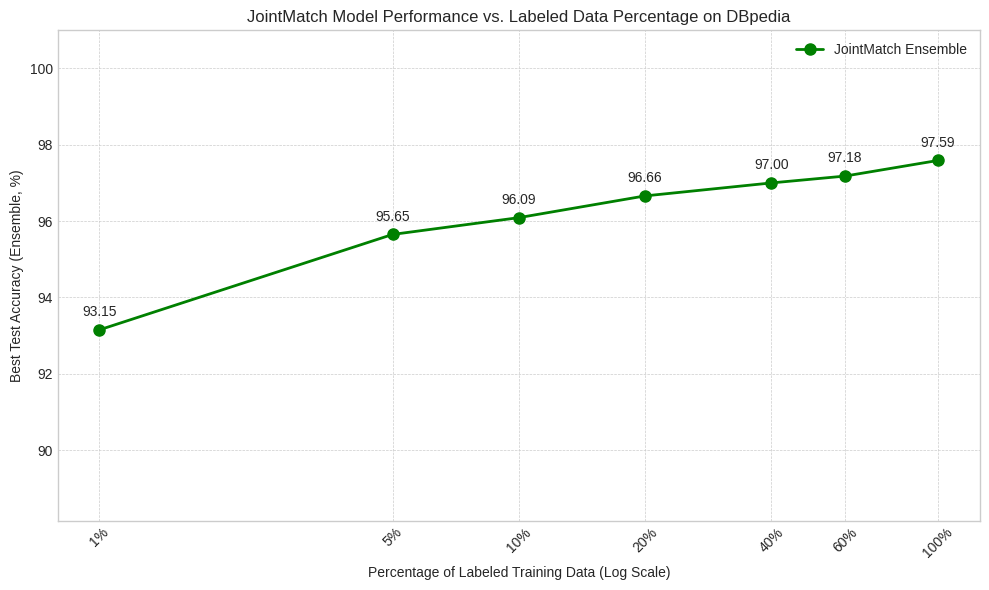


--- Evaluating Best JointMatch Models for 10% Labeled Data ---
Loading models from: /kaggle/working/saved_models_jointmatch/jointmatch_dbpedia_best_10pct.pth
Models loaded successfully from epoch 26.
    Evaluating... (79 batches) Done (0.38s)
  Final Ensemble Test Accuracy (10% Labeled): 96.09%

Classification Report (10% Run - Ensemble):

                        precision    recall  f1-score   support

               Company     0.9519    0.9133    0.9322       715
EducationalInstitution     0.9562    0.9776    0.9668       714
                Artist     0.9236    0.9314    0.9275       714
               Athlete     0.9721    0.9762    0.9741       714
          OfficeHolder     0.9689    0.9608    0.9648       714
  MeanOfTransportation     0.9630    0.9832    0.9730       714
              Building     0.9532    0.9412    0.9471       714
          NaturalPlace     0.9722    0.9804    0.9763       714
               Village     0.9929    0.9832    0.9880       714
               

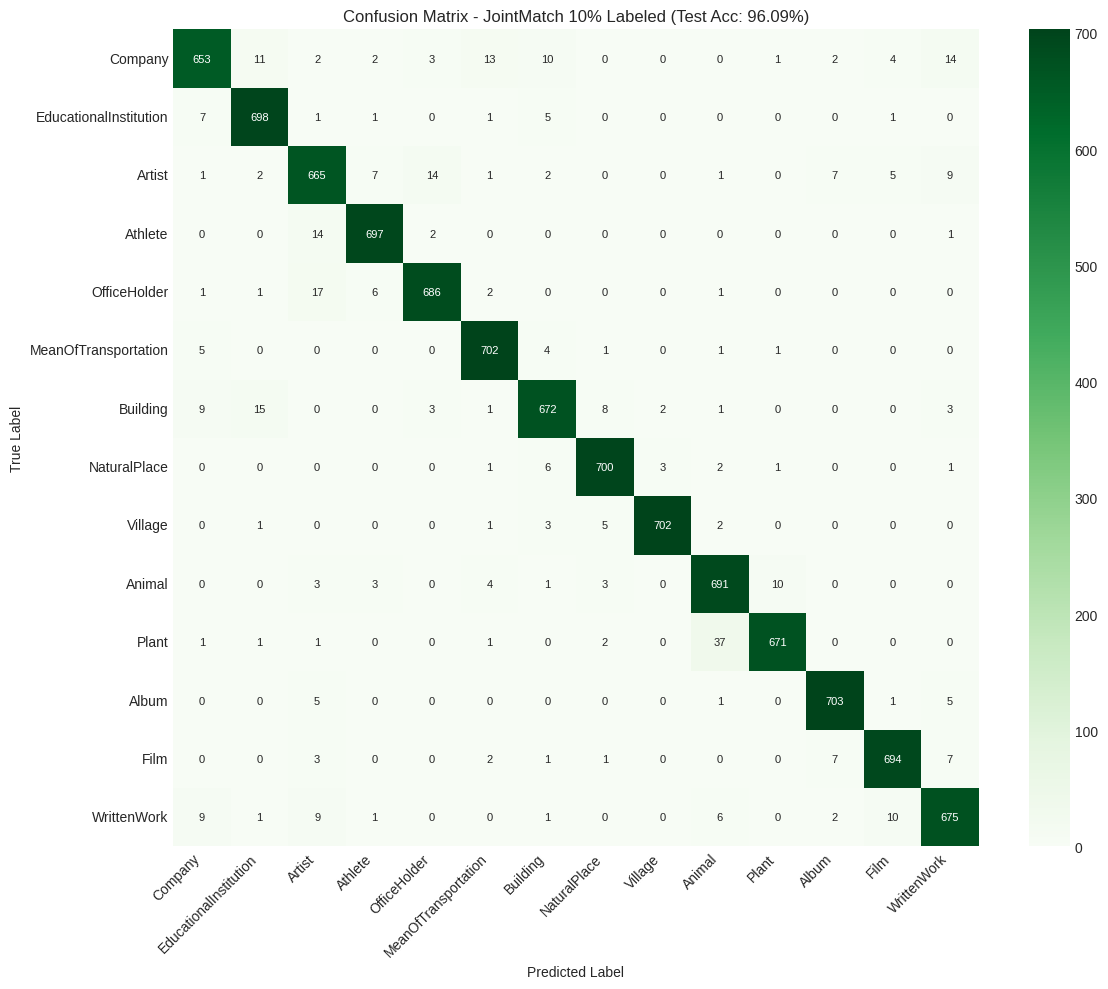

In [ ]:
# 11. results summary & visualization

print("\n===== jointmatch experiment summary =====")

if not experiment_results:
    print("no results to display.")
else:
    sorted_percentages = sorted(experiment_results.keys())
    accuracies = [experiment_results[p]['best_test_accuracy'] for p in sorted_percentages]
    percentage_labels = [f"{p*100:.0f}%" for p in sorted_percentages]

    print("percentage labeled | best ensemble test accuracy (%)")
    print("-------------------|---------------------------------")
    for i, p in enumerate(sorted_percentages):
        print(f"{p*100:>18.1f}% | {accuracies[i]:>31.2f}%" )

    # plotting accuracy vs labeled percentage
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(10, 6))
    plt.plot(sorted_percentages, accuracies, 'go-', markersize=8, linewidth=2, label='jointmatch ensemble')
    plt.title('jointmatch model performance vs. labeled data percentage on dbpedia')
    plt.xlabel('percentage of labeled training data (log scale)')
    plt.ylabel('best test accuracy (ensemble, %)')
    plt.gca().set_xscale('log') # use log scale
    plt.xticks(sorted_percentages, labels=percentage_labels, rotation=45)
    plt.minorticks_off() # clean up log scale ticks
    plt.ylim(bottom=max(0, min(accuracies)-5) if accuracies else 0, top=101)
    plt.grid(True, which="both", ls="--", linewidth=0.5)

    # annotate points
    for i, txt in enumerate(accuracies):
        plt.annotate(f'{txt:.2f}', (sorted_percentages[i], accuracies[i]), textcoords="offset points", xytext=(0,10), ha='center')

    plt.legend()
    plt.tight_layout()
    plt.show()

# load and evaluate the best model for 10% labeled data
if 0.1 in experiment_results:
    print("\n--- evaluating best jointmatch models for 10% labeled data ---")
    best_10pct_path = experiment_results[0.1]['model_path']
    print(f"loading models from: {best_10pct_path}")

    if os.path.exists(best_10pct_path):
        try:
            # load the dictionary containing both state dicts and config
            # use map_location=device ensures model loaded to correct device
            checkpoint = torch.load(best_10pct_path, map_location=device, weights_only=False) # use weights_only=True if safe

            # re-initialize model architectures using saved config
            config = checkpoint.get('config', {})
            loaded_vocab_size = config.get('VOCAB_SIZE', vocab_size) # fallback to global if not saved
            loaded_embed_dim = config.get('EMBED_DIM', embed_dim)
            loaded_hidden_dim = config.get('HIDDEN_DIM', hidden_dim)
            loaded_num_classes = config.get('NUM_CLASSES', num_classes)
            loaded_dropout = config.get('DROPOUT', dropout)
            loaded_pad_idx = config.get('PAD_IDX', pad_idx)
            # retrieve vocab if saved, otherwise use the globally defined one
            loaded_vocab = checkpoint.get('vocab', vocab)
            loaded_unk_idx = loaded_vocab.get('<unk>', unk_idx)

            # important: recreate test dataloader with loaded vocab/pad_idx if different
            if loaded_pad_idx != pad_idx or loaded_vocab != vocab:
                print("warning: loaded model used different vocab/padding. recreating test loader.")
                # ensure df_test_cleaned exists and is used
                if 'df_test_cleaned' not in locals() or df_test_cleaned.empty:
                    print("error: cannot recreate test loader, cleaned test data not available.")
                    raise runtimeerror("cleaned test data needed for evaluation missing.")

                temp_test_dataset = textclassificationdataset(df_test_cleaned, loaded_vocab, simple_tokenizer, loaded_unk_idx, is_unlabeled=False)
                temp_collate_fn_labeled = partial(collate_batch, pad_idx=loaded_pad_idx, is_unlabeled=False)
                current_test_loader = dataloader(temp_test_dataset, batch_size=batch_size*2, shuffle=False,
                                                                    collate_fn=temp_collate_fn_labeled, num_workers=0, pin_memory=True)
            else:
                current_test_loader = test_loader # use existing one


            eval_model_f = textclassifier(
                vocab_size=loaded_vocab_size, embed_dim=loaded_embed_dim, hidden_dim=loaded_hidden_dim,
                num_classes=loaded_num_classes, dropout=loaded_dropout, pad_idx=loaded_pad_idx
            ).to(device)
            eval_model_g = textclassifier(
                vocab_size=loaded_vocab_size, embed_dim=loaded_embed_dim, hidden_dim=loaded_hidden_dim,
                num_classes=loaded_num_classes, dropout=loaded_dropout, pad_idx=loaded_pad_idx
            ).to(device)

            eval_model_f.load_state_dict(checkpoint['model_f_state_dict'])
            eval_model_g.load_state_dict(checkpoint['model_g_state_dict'])
            print(f"models loaded successfully from epoch {checkpoint.get('epoch', 'n/a')}.")

            # evaluate on the test set using the ensemble
            final_test_loss, final_test_accuracy, all_labels, all_preds = evaluate_jointmatch(
                eval_model_f, eval_model_g, current_test_loader, classification_criterion_mean, device
            )
            print(f"  final ensemble test accuracy (10% labeled): {final_test_accuracy:.2f}%")

            # display classification report/confusion matrix for this run
            print("\nclassification report (10% run - ensemble):\n")
            class_names = [
                'company', 'educationalinstitution', 'artist', 'athlete', 'officeholder',
                'meanoftransportation', 'building', 'naturalplace', 'village', 'animal',
                'plant', 'album', 'film', 'writtenwork'
            ]
            if len(class_names) != num_classes: class_names = [f'class {i}' for i in range(num_classes)]
            print(classification_report(all_labels, all_preds, target_names=class_names, digits=4, zero_division=0))

            print("\nconfusion matrix (10% run - ensemble):")
            cm = confusion_matrix(all_labels, all_preds)
            plt.figure(figsize=(12, 10))
            sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
                                xticklabels=class_names, yticklabels=class_names, annot_kws={"size": 8})
            plt.title(f"confusion matrix - jointmatch 10% labeled (test acc: {final_test_accuracy:.2f}%)")
            plt.xlabel("predicted label")
            plt.ylabel("true label")
            plt.xticks(rotation=45, ha='right')
            plt.yticks(rotation=0)
            plt.tight_layout()
            plt.show()

            del eval_model_f, eval_model_g # clean up models
            if 'temp_test_dataset' in locals(): del temp_test_dataset # clean up temp dataset if created

        except exception as e:
            print(f"error loading model state dicts or evaluating: {e}")
            print("ensure the saved file contains 'model_f_state_dict' and 'model_g_state_dict'.")

    else:
        print(f"model file not found at {best_10pct_path}")

    gc.collect()
    if torch.cuda.is_available(): torch.cuda.empty_cache()
